SV phải TỰ thu thập dữ liệu (tự crawl).

Số lượng: >1000 mẫu, dẫn nguồn dữ liệu và mô tả cách thức thu thập. 

Xuất ra các thống kê mô tả trực quan về dữ liệu.

In [ ]:
from bs4 import BeautifulSoup
from bs4.element import Tag
import requests
import csv
import pandas as pd
import openpyxl
import sys
Title = []
PlantType = []
Hardiness = []
ClimateZones = []
PlantFamily = []
Exposure = []
Season = []
Height = []
Speard = []
WaterNeeds = []
SoilType = []
SoilpH = []
SoilDrainage = []
Characteristics = []
Tolerance = []
GardenUses = []
GardenStyles = []

# sys.stdout.reconfigure(encoding='utf-8')
a = {'Name':Title,'Hardiness': Hardiness,'Climate Zones':ClimateZones,'Plant Type':PlantType,'Plant Family':PlantFamily,
     'Exposure':Exposure, 'Season of Interest': Season, 'Height': Height, 'Spread': Speard, 'Water Needs' : WaterNeeds, 
	 "Soil Type": SoilType, "Soil pH": SoilpH, "Soil Drainage": SoilDrainage, "Characteristics": Characteristics, 
	 "Tolerance": Tolerance, "Garden Uses": GardenUses, "Garden Styles": GardenStyles}
def crawl():
	n = 0
	for i in range(1, 100):
		print(i)
		headers = {"User-Agent": "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:108.0) Gecko/20100101 Firefox/108.0"}
		req = requests.get(f"https://www.gardenia.net/plants/plant-types/shrubs?page={i}", headers=headers)  # URL of the website which you want to scrape
		content = req.content  # Get the content
		soup = BeautifulSoup(content, 'html.parser')
		links = soup.select(".grid-img > a")	
		for link in links :
			n+=1
			productPage = requests.get("{}".format(link.attrs["href"]) , headers = headers)
			productsoup = BeautifulSoup(productPage.content, 'html.parser')
			a['Name'].append(productsoup.select("body > div.container > div.main-body > div.body-heading > h1")[0].contents[0].text.strip())
			print(a['Name'][-1])
			infoRows = productsoup.select("div.d-lg-block > table > tbody > tr")
			img_url = productsoup.select("#carouselExampleControls > div > div > img")[0].attrs["data-src"]
			#carouselExampleControls > div > div > img
			crawl_image(img_url,n)
			for row in infoRows:
				th = row.find_all("th")[0].contents[0].text.strip()
				td = row.find_all("td")[0].contents[0].text.strip()
				if (th == "Garden Uses"):
					content = ""
					aTags = row.find_all("td")[0].find_all('a')
					for aTag in aTags:
						content += aTag.contents[0].text.strip() + ","
					content = content[0:-1]
					a[th].append(content)
					continue
				elif (th == "Garden Styles"):
					content = ""
					aTags = row.find_all("td")[0].find_all('a')
					for aTag in aTags:
						content += aTag.contents[0].text.strip() + ","
					content = content[0:-1]
					a[th].append(content)
					continue
				elif th in a.keys():
					a[th].append(td)
			append_null()
	save()
def crawl_image(img_url, i):
	response = requests.get(img_url)
	if response.status_code != 404:
		fp = open(f'Images/hoa{i}.jpg', 'wb')
		fp.write(response.content)
		fp.close()


def append_null():
	maxx = len(a["Name"])
	for key in a.keys():
		if len(a[key]) < maxx:
			a[key].append(None)

def save():
	
	df = pd.DataFrame.from_dict(a, orient='index')
	df = df.transpose()
	dataset = pd.DataFrame(data=df)
	dataset.to_csv('Shrubs.csv', encoding='utf-8-sig', )

if __name__ == '__main__':
	crawl()
	

-Trình bày việc lựa chọn đặc trưng, làm sạch và chuẩn hóa dữ liệu, giảm chiều, 

-Trực quan hoá kết quả của các quá trình trên. 

Lựa chọn đặc trưng

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.impute import SimpleImputer
import csv
import codecs
import io
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression




df = pd.read_csv('Shrubs_cleaned.csv', index_col=0)

# Select features
features = ['Hardiness','Climate Zones', 'Plant Family','Season of Interest','Min-Height(feet)','Max-Height(feet)', 'Min-Height(cm)', 'Max-Height(cm)', 'Characteristics', 'Soil Type']

label = 'Plant Type'

new_plant = {'Hardiness': '7\n– 11', 
             'Climate Zones': '17', 
             'Plant Family': 'cupressus - cypresses', 
             'Season of Interest': 'spring (early,mid,late)', 
             'Min-Height(feet)': "10",
             'Max-Height(feet)': "12",
             'Min-Height(cm)': "3m",
             'Max-Height(cm)': "3.6m",
            #  'Height': "10'\n– 12'\n(3m\n– 3.6m)", 
             'Characteristics': 'fragrant, plant of merit, showy, evergreen', 
             'Soil Type': 'chalk, clay, loam, sand'}

for feature in features:
  if feature in new_plant.keys():
    print(df[feature])
    print("---------")
    print(new_plant[feature])
    new_plant[feature] = pd.factorize(df[feature])[0][df[feature] == new_plant[feature]][0]
print("new plant: ")
print(new_plant)

# Convert categorical features to numerical
for feature in features:
  df[feature] = pd.factorize(df[feature])[0]
# df[label] = pd.factorize(df[label])[0]

df.to_csv("Shrubs1.csv", index=False)

# print(X.columns)
label_encoder = LabelEncoder()
label_encoder1 = LabelEncoder() 
X = df[features]
#X = label_encoder.fit_transform(df[features])
y = label_encoder1.fit_transform(df[label])

#y = df[label]
plant_type_map = dict(zip(label_encoder1.transform(label_encoder1.classes_), label_encoder1.classes_))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Xây dựng mô hình Random Forest và huấn luyện trên tập huấn luyện
lr = RandomForestRegressor()
lr.fit(X_train, y_train)

# Đánh giá mô hình trên tập kiểm tra
y_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE:", mse)
print("R-squared:", r2)

new_plant_encoded = pd.get_dummies(pd.DataFrame(new_plant, index=[0]))[X.columns]
predicted_plant_type = lr.predict(new_plant_encoded)[0]
predicted_plant_type = int(predicted_plant_type)
print("Loại cây (số nguyên):", predicted_plant_type)

# Chuyển đổi kết quả sang giá trị ban đầu
predicted_plant_type_name = plant_type_map[predicted_plant_type]
print("Loại cây (tên):", predicted_plant_type_name)

Làm sạch dữ liệu

In [ ]:
#Loại bỏ các dòng trống hoặc các giá trị rỗng trong các cột.
import pandas as pd
# làm sạch dữ liệu
df=pd.read_csv('Shrubs.csv')
df = df.dropna()
#Chuyển đổi các giá trị chuỗi thành kiểu dữ liệu phù hợp, ví dụ: các giá trị kiểu số được chuyển đổi sang kiểu dữ liệu số.
# đơn vị feet
df[['Min-Height(feet)','Max-Height(feet)']] = df['Height'].apply(lambda x: pd.Series(str(x).split("(")[0].split("–")))
df['Min-Height(feet)']=df['Min-Height(feet)'].apply(lambda x: pd.Series(str(x).strip().replace("'",'')))
df['Max-Height(feet)']=df['Max-Height(feet)'].apply(lambda x: pd.Series(str(x).strip().replace("'",'')))
df['Min-Height(feet)']=df['Min-Height(feet)'].apply(lambda x: pd.Series(str(x).strip().replace('"','')))
df['Max-Height(feet)']=df['Max-Height(feet)'].apply(lambda x: pd.Series(str(x).strip().replace('"','')))


df[['Min-Height(cm)','Max-Height(cm)']]= df['Height'].apply(lambda x: pd.Series(str(x).split("(")[1].split("–")))
df['Min-Height(cm)']=df['Min-Height(cm)'].apply(lambda x: pd.Series(str(x).strip().replace("cm",'')))
df['Max-Height(cm)']=df['Max-Height(cm)'].apply(lambda x: pd.Series(str(x).strip().replace("cm",'')))
df['Max-Height(cm)']=df['Max-Height(cm)'].apply(lambda x: pd.Series(str(x).strip().replace(")",'')))


df[['Min-Spread(feet)','Max-Spread(feet)']] = df['Spread'].apply(lambda x: pd.Series(str(x).split("(")[0].split("–")))
df['Min-Spread(feet)']=df['Min-Spread(feet)'].apply(lambda x: pd.Series(str(x).strip().replace("'",'')))
df['Max-Spread(feet)']=df['Max-Spread(feet)'].apply(lambda x: pd.Series(str(x).strip().replace("'",'')))
df['Min-Spread(feet)']=df['Min-Spread(feet)'].apply(lambda x: pd.Series(str(x).strip().replace('"','')))


df[['Min-Spread(cm)','Max-Spread(cm)']]= df['Spread'].apply(lambda x: pd.Series(str(x).split("(")[1].split("–")))
df['Min-Spread(cm)']=df['Min-Spread(cm)'].apply(lambda x: pd.Series(str(x).strip().replace("cm",'')))
df['Max-Spread(cm)']=df['Max-Spread(cm)'].apply(lambda x: pd.Series(str(x).strip().replace("cm",'')))
df['Max-Spread(cm)']=df['Max-Spread(cm)'].apply(lambda x: pd.Series(str(x).strip().replace(")",'')))

df[['Hardiness(Min)','Hardiness(Max)']]= df['Hardiness'].apply(lambda x: pd.Series(str(x).split("–")))


df['Soil pH'] = pd.to_numeric(df['Soil pH'], errors='coerce')
#Loại bỏ các dấu phẩy trong các giá trị chuỗi để giúp việc xử lý dữ liệu dễ dàng hơn.
df['Garden Uses'] = df['Garden Uses'].str.split(',')
df['Garden Styles'] = df['Garden Styles'].str.split(',')
#Loại bỏ các khoảng trắng không cần thiết.
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
#Loại bỏ các ký tự đặc biệt và chuyển đổi các giá trị sang chữ thường để dễ dàng sử dụng và tìm kiếm.
df = df.apply(lambda x: x.str.lower() if x.dtype == "object" else x)
df['Name'] = df['Name'].str.replace('[^a-zA-Z0-9 \n\.]', '')
#Sau khi làm sạch dữ liệu, chúng ta có thể lưu lại dữ liệu đã làm sạch vào một file mới bằng cách sử dụng phương thức to_csv() của pandas.
df.to_csv('Shrubs_cleaned.csv', encoding='utf-8-sig', index=False)

<ipython-input-2-a698899aff0b>:19: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Name'] = df['Name'].str.replace('[^a-zA-Z0-9 \n\.]', '')


Chuẩn hóa dữ liệu

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# chuẩn hóa dữ liệu
# Tạo một instance của MinMaxScaler
df=pd.read_csv('Shrubs.csv')
scaler = MinMaxScaler()

# Chuẩn hóa dữ liệu cho feature "Height"
df['Height'],u=pd.factorize(df['Height'])
height = df[['Height']]
height_scaled = scaler.fit_transform(height)

# Gán lại giá trị đã chuẩn hóa cho feature "Height" vào trong dfset
df['Height'] = height_scaled
print(height_scaled)

[[0.        ]
 [0.00645161]
 [0.00645161]
 ...
 [0.00645161]
 [0.12903226]
 [0.12903226]]


Giảm chiều dữ liệu

(1485, 2)


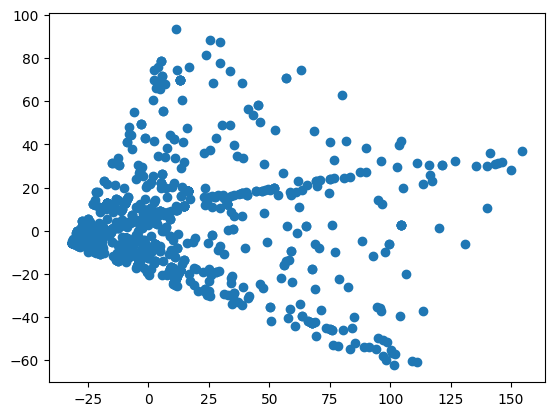

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
#Giamr chiều dữ liệu
# Đọc dữ liệu từ file csv
df = pd.read_csv('Shrubs.csv')

# Chọn các cột chứa dữ liệu cần giảm chiều
cols = ['Height', 'Spread', 'Water Needs', 'Soil pH', 'Soil Drainage']
for col in cols:
    df[col] =pd.factorize(df[col])[0]
# Tạo một instance của PCA với số chiều mới là 2
pca = PCA(n_components=2)

# Áp dụng PCA cho dfset
dfset_reduced = pca.fit_transform(df[cols])

# In ra kích thước của dfset sau khi giảm chiều
print(dfset_reduced.shape)

# Vẽ biểu đồ scatter plot của dfset giảm chiều với 2 trục mới
plt.scatter(dfset_reduced[:, 0], dfset_reduced[:, 1])
plt.show()

In [ ]:
# Giảm chiều dữ liệu
import pandas as pd
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

df = pd.read_csv('Shrubs.csv')


cols = ['Height', 'Spread', 'Water Needs', 'Soil pH', 'Soil Drainage']
for col in cols:
    df[col] =pd.factorize(df[col])[0]
#Áp đặt các giá trị bị thiếu với giá trị trung bình
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(df[cols])
#thuật toán giảm chiều PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_imputed)

print("Dữ liệu gốc:\n", df[cols])
print("Dữ liệu sau khi gán giá trị còn thiếu:\n", X_imputed)
print("Dữ liệu sau khi giảm chiều:\n", X_pca)

Dữ liệu gốc:
       Height  Spread  Water Needs  Soil pH  Soil Drainage
0          0       0            0        0              0
1          1       1            0        0              0
2          1       2            0        0              0
3          1       2            0        0              0
4          2       3            0        0              0
...      ...     ...          ...      ...            ...
1480      46       1            0        0              0
1481      46       1            0        4              0
1482       1       6            0        4              0
1483      20      11            0        4              0
1484      20      11            0        4              0

[1485 rows x 5 columns]
Dữ liệu sau khi gán giá trị còn thiếu:
 [[ 0.  0.  0.  0.  0.]
 [ 1.  1.  0.  0.  0.]
 [ 1.  2.  0.  0.  0.]
 ...
 [ 1.  6.  0.  4.  0.]
 [20. 11.  0.  4.  0.]
 [20. 11.  0.  4.  0.]]
Dữ liệu sau khi giảm chiều:
 [[-31.7312762   -5.79225268]
 [-30.42027586  -5.2619

Chọn các mô hình phù hợp (ít nhất 2 mô hình/thuật toán).- Chia dữ liệu thành Train/Validation/Test set theo tỉ lệ phù hợp.
- Trình bày các đồ thị thể hiện hiệu quả của các mô hình trong quá trình huấn luyện/Hiệu chỉnh/Kiểm thử.
- So sánh hiệu quả của các mô hình bằng bảng dữ liệu hoặc đồ thị.

Chọn các mô hình phù hợp (ít nhất 2 mô hình/thuật toán).- Chia dữ liệu thành Train/Validation/Test set theo tỉ lệ phù hợp.
- Chọn 2 mô hình random forest và naive bayes

CNN không dùng được vì không có ảnh,KNN không dùng epoch, RNN thường được sử dụng để mô hình hóa các dữ liệu chuỗi thời gian như tín hiệu âm thanh,SVM dùng giống KNN fit and predict

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Đọc dữ liệu từ file csv
df = pd.read_csv('Shrubs.csv')

# Chọn các feature để huấn luyện mô hình
features = ['Hardiness', 'Climate Zones', 'Plant Type', 'Exposure', 'Season of Interest', 
            'Height', 'Spread', 'Water Needs', 'Soil Type', 'Soil pH', 'Soil Drainage']
for feature in features:
    df[feature] = pd.factorize(df[feature])[0]

# Chọn target để huấn luyện mô hình
target = 'Plant Type'
df[target]=pd.factorize(df[target])[0]
# Tách dữ liệu thành 3 tập: train, validation và test
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Tạo và huấn luyện mô hình random forest
rf_model = GaussianNB()
rf_model.fit(X_train, y_train)

# Đánh giá mô hình trên tập validation
val_score = rf_model.score(X_val, y_val)
print('Validation score:', val_score)

# Đánh giá mô hình trên tập test
test_score = rf_model.score(X_test, y_test)
print('Test score:', test_score)

Validation score: 0.9865319865319865
Test score: 0.9797979797979798


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Đọc dữ liệu từ file csv
df = pd.read_csv('Shrubs.csv')

# Chọn các feature để huấn luyện mô hình
features = ['Hardiness', 'Climate Zones', 'Plant Type', 'Exposure', 'Season of Interest', 
            'Height', 'Spread', 'Water Needs', 'Soil Type', 'Soil pH', 'Soil Drainage']
for feature in features:
    df[feature] = pd.factorize(df[feature])[0]

# Chọn target để huấn luyện mô hình
target = 'Plant Type'
df[target]=pd.factorize(df[target])[0]
# Tách dữ liệu thành 3 tập: train, validation và test
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
# Tạo và huấn luyện mô hình random forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Đánh giá mô hình trên tập validation
val_score = rf_model.score(X_val, y_val)
print('Validation score:', val_score)

# Đánh giá mô hình trên tập test
test_score = rf_model.score(X_test, y_test)
print('Test score:', test_score)

Validation score: 0.9696969696969697
Test score: 0.9663299663299664


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
df = pd.read_csv('Shrubs.csv')
# Chọn các feature để huấn luyện mô hình
features = ['Hardiness', 'Climate Zones', 'Plant Type', 'Exposure', 'Season of Interest', 
            'Height', 'Spread', 'Water Needs', 'Soil Type', 'Soil pH', 'Soil Drainage']
for feature in features:
    df[feature] = pd.factorize(df[feature])[0]

# Chọn target để huấn luyện mô hình
target = 'Plant Type'
df[target]=pd.factorize(df[target])[0]

# Split data into Train/Validation/Test sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Train KNN model
k = 3
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

# Evaluate KNN model on Validation set
y_pred_val = knn.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred_val)
print(f'Validation accuracy: {val_accuracy:.2f}')

# Evaluate KNN model on Test set
y_pred_test = knn.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f'Test accuracy: {test_accuracy:.2f}')

Validation accuracy: 0.75
Test accuracy: 0.73


- Trình bày các đồ thị thể hiện hiệu quả của các mô hình trong quá trình huấn luyện/Hiệu chỉnh/Kiểm thử.
- So sánh hiệu quả của các mô hình bằng bảng dữ liệu hoặc đồ thị.

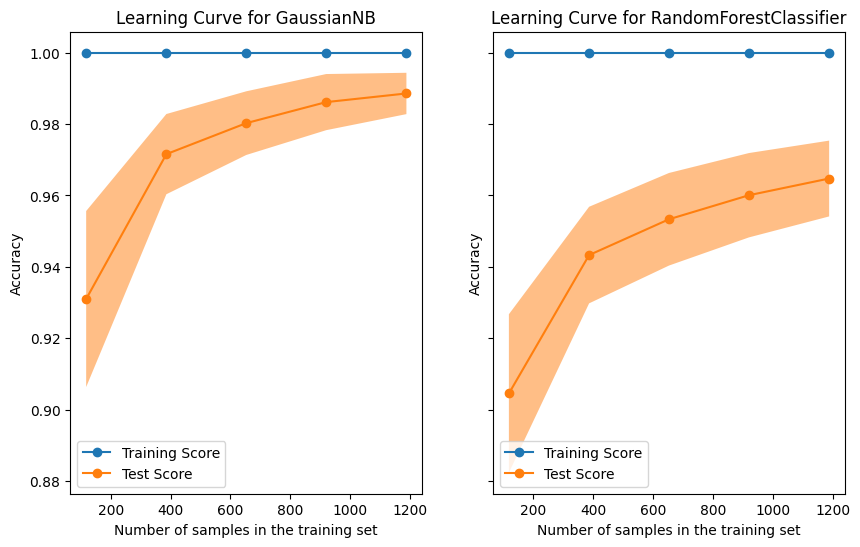

In [ ]:
#%%
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
from sklearn.model_selection import learning_curve

naive_bayes = GaussianNB()
rf = RandomForestClassifier(n_estimators=100, random_state=42)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

df = pd.read_csv('Shrubs.csv', index_col=0)

# Select features
features = ['Hardiness', 'Climate Zones', 'Plant Type', 'Exposure', 'Season of Interest', 
            'Height', 'Spread', 'Water Needs', 'Soil Type', 'Soil pH', 'Soil Drainage']
label = 'Plant Type'

# Convert categorical features to numerical
for feature in features:
    df[feature] = pd.factorize(df[feature])[0]
df[label] = pd.factorize(df[label])[0]
    
X = df[features]
y = df[label]
common_params = {
    "X": X,
    "y": y,
    "train_sizes":   np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=100, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}


for ax_idx, estimator in enumerate([naive_bayes, rf ]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")
    
fig.show()

# %%


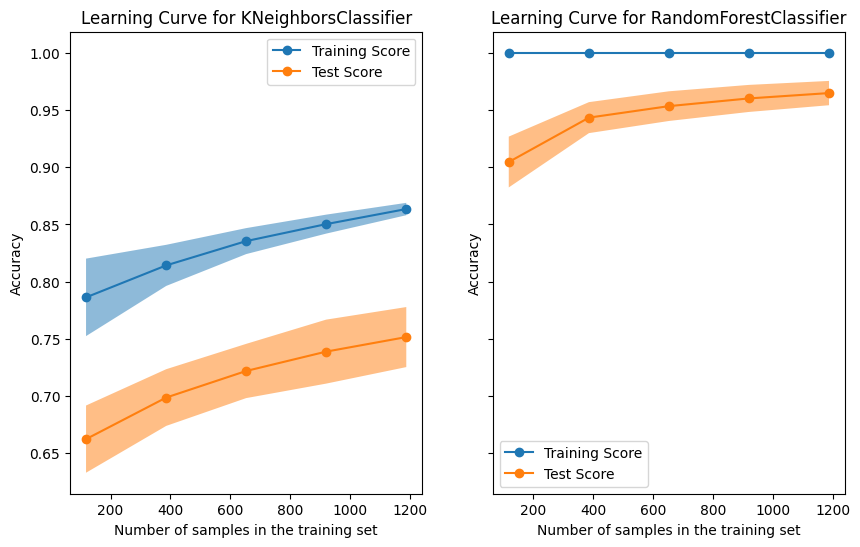

In [ ]:
#%%
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
from sklearn.model_selection import learning_curve

knn = KNeighborsClassifier(n_neighbors=3)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

df = pd.read_csv('Shrubs.csv', index_col=0)

# Select features
features = ['Hardiness', 'Climate Zones', 'Plant Type', 'Exposure', 'Season of Interest', 
            'Height', 'Spread', 'Water Needs', 'Soil Type', 'Soil pH', 'Soil Drainage']
label = 'Plant Type'

# Convert categorical features to numerical
for feature in features:
    df[feature] = pd.factorize(df[feature])[0]
df[label] = pd.factorize(df[label])[0]
    
X = df[features]
y = df[label]
common_params = {
    "X": X,
    "y": y,
    "train_sizes":   np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=100, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}


for ax_idx, estimator in enumerate([knn, rf ]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")
    
fig.show()

# %%


LÀM MÔ HÌNH CNN


In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os
# Load data from csv file



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd '/content/drive/MyDrive/'

/content/drive/MyDrive


In [5]:
!unzip Images.zip

Archive:  Images.zip
   creating: Images/
   creating: Images/Annuals/
  inflating: Images/Annuals/hoa1.jpg  
  inflating: Images/Annuals/hoa10.jpg  
  inflating: Images/Annuals/hoa100.jpg  
  inflating: Images/Annuals/hoa101.jpg  
  inflating: Images/Annuals/hoa102.jpg  
  inflating: Images/Annuals/hoa103.jpg  
  inflating: Images/Annuals/hoa104.jpg  
  inflating: Images/Annuals/hoa105.jpg  
  inflating: Images/Annuals/hoa106.jpg  
  inflating: Images/Annuals/hoa107.jpg  
  inflating: Images/Annuals/hoa108.jpg  
  inflating: Images/Annuals/hoa109.jpg  
  inflating: Images/Annuals/hoa11.jpg  
  inflating: Images/Annuals/hoa110.jpg  
  inflating: Images/Annuals/hoa111.jpg  
  inflating: Images/Annuals/hoa112.jpg  
  inflating: Images/Annuals/hoa113.jpg  
  inflating: Images/Annuals/hoa114.jpg  
  inflating: Images/Annuals/hoa115.jpg  
  inflating: Images/Annuals/hoa116.jpg  
  inflating: Images/Annuals/hoa117.jpg  
  inflating: Images/Annuals/hoa118.jpg  
  inflating: Images/Annuals/hoa

In [8]:
pts = os.listdir('Images')
pts

['Annuals',
 'Aquatic',
 'Bulbs',
 'Climbers',
 'Conifers',
 'Fruits',
 'Orchids',
 'Ornamental Grasses',
 'Roses',
 'Shrubs',
 'Trees']

In [9]:
import tensorflow as tf
image_dataset_from_directory = tf.keras.utils.image_dataset_from_directory

In [10]:
import os
import cv2
for pth in os.listdir('Images'):
    path = os.path.join('Images', pth)
    for file in os.listdir(path):
        if file.endswith(".jpg") or file.endswith(".JPG"):
            img_path = os.path.join(path, file)
            img = cv2.imread(img_path)
            cv2.imwrite(img_path[0:-4]+".jpeg", img)
            os.remove(img_path)

In [11]:
images_path='Images'
train_ds = image_dataset_from_directory(
    images_path,
    validation_split=0.2,
    subset='training',
    seed=0,
)
val_ds = image_dataset_from_directory(
    images_path,
    validation_split=0.2,
    subset='training',
    seed=0,
)

Found 2588 files belonging to 11 classes.
Using 2071 files for training.
Found 2588 files belonging to 11 classes.
Using 2071 files for training.


In [12]:
class_names = train_ds.class_names

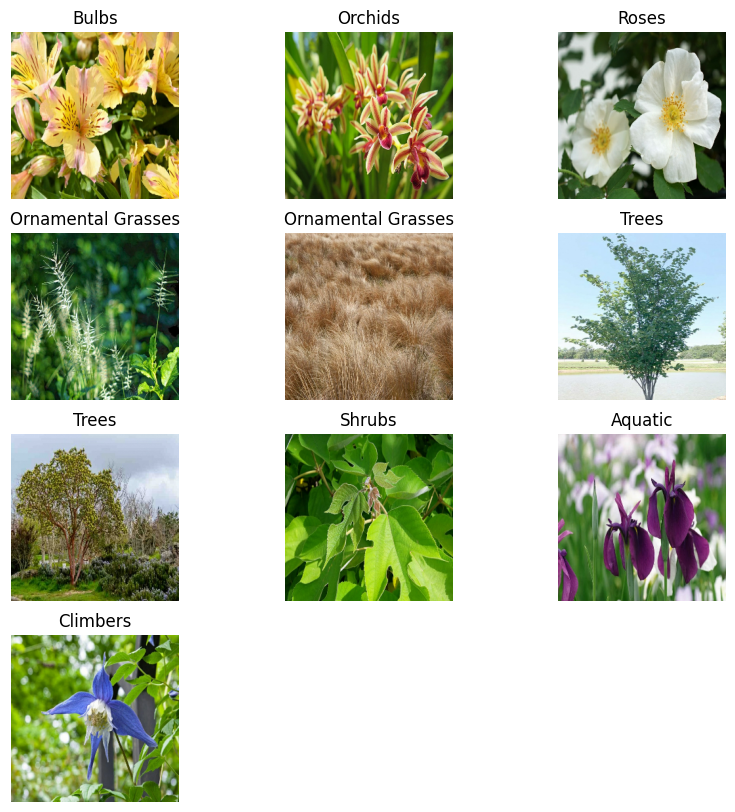

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(10):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [14]:
class_names = train_ds.class_names
len(class_names)

11

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 256, 256, 3)
(32,)


In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
# Define the model
layers = tf.keras.layers
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
num_classes = len(class_names)



model = Sequential([
  layers.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])




model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

model.summary()
# Train the model
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)# Evaluate the model on test set
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1